# Loan Classification

Data source: [source](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/#About)

In [149]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation and bayesian optimization
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [150]:
# Make scorer: accuracy
accuracy = make_scorer(accuracy_score)

# Load dataset
trainSet = pd.read_csv("train_loan.csv")
trainSet.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [151]:
# Data preparation
train = trainSet.dropna(axis=0)
train = train.drop(columns=["Loan_ID"])
train["Gender"] = np.where(train["Gender"] == "Male", 1, 0)
train["Married"] = np.where(train["Married"] == "Yes", 1, 0)
train["Dependents"] = np.where(
    train["Dependents"] == "0",
    0,
    np.where(train["Dependents"] == "1", 1, np.where(train["Dependents"] == "2", 2, 3)),
)
train["Education"] = np.where(train["Education"] == "Graduate", 1, 0)
train["Self_Employed"] = np.where(train["Self_Employed"] == "Yes", 1, 0)
train["Loan_Status"] = np.where(train["Loan_Status"] == "Y", 1, 0)
train = pd.get_dummies(train, columns=["Property_Area"])
label = train.pop("Loan_Status")
train.insert(0, "Loan_Status", label)
train.head()

,Loan_Status,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,0,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,1,0,0
2,1,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,0,0,1
3,1,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,0,0,1
4,1,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,0,0,1
5,1,1,1,2,1,1,5417,4196.0,267.0,360.0,1.0,0,0,1


In [152]:
# train validation split for feature selection
X_train, X_val, y_train, y_val = train_test_split(
    train.drop(columns=["Loan_Status"], axis=0),
    train["Loan_Status"],
    test_size=0.2, random_state=123,
    stratify=train["Loan_Status"]
)

In [156]:
# Hyperparameter tuning: Bayesian Optimization
def xgb_cl_bo(n_estimators, max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree):
    params_xgb = {
    "objective": "multi:softmax",
    "nthread": -1,
    "num_class": 2,
    }
    params_xgb["n_estimators"] = round(n_estimators)
    params_xgb["max_depth"] = round(max_depth)
    params_xgb["learning_rate"] = learning_rate
    params_xgb["gamma"] = gamma
    params_xgb["min_child_weight"] = round(min_child_weight)
    params_xgb["subsample"] = subsample
    params_xgb["colsample_bytree"] = colsample_bytree

    score = cross_val_score(
        XGBClassifier(random_state=123, **params_xgb),
        X_train,
        y_train,
        scoring=accuracy,
        cv=5
    ).mean()

    return score

# Set parameters distribution
params_xgb ={
    "n_estimators": (80, 150),
    "max_depth": (3, 15),
    "learning_rate": (0.01, 0.5),
    "gamma":(0, 10),
    "min_child_weight":(3, 20),
    "subsample":(0.5, 1),
    "colsample_bytree":(0.1, 1)
}

# Run Bayesian Optimization
xgb_bo = BayesianOptimization(xgb_cl_bo, params_xgb, random_state=111)
xgb_bo.maximize(init_points=4, n_iter=20)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.8046   |  0.651    |  1.691    |  0.2237   |  12.23    |  8.021    |  90.44    |  0.5112   |
|  2        |  0.8176   |  0.4782   |  2.387    |  0.1755   |  14.89    |  7.041    |  85.68    |  0.8348   |
|  3        |  0.815    |  0.6591   |  2.743    |  0.2384   |  4.42     |  4.257    |  143.1    |  0.897    |
|  4        |  0.6927   |  0.8565   |  8.152    |  0.4956   |  9.927    |  16.83    |  109.5    |  0.5137   |
|  5        |  0.6927   |  0.1      |  0.0      |  0.01     |  15.0     |  20.0     |  150.0    |  0.752    |
|  6        |  0.815    |  0.7267   |  0.0      |  0.01     |  3.916    |  3.0      |  80.0     |  1.0      |
|  7        |  0.815    |  1.0      |  0.0      |  0.01     |  7.288    |  20.0     |  80.0     |  1.0      |
|  8      

In [157]:
# Best hyperparameters
params_xgb = xgb_bo.max["params"]
params_xgb["objective"] = "multi:softmax"
params_xgb["n_jobs"] = -1
params_xgb["n_estimators"] = round(params_xgb["n_estimators"])
params_xgb["max_depth"] = round(params_xgb["max_depth"])
params_xgb["min_child_weight"] = round(params_xgb["min_child_weight"])
params_xgb["num_class"] = 2
params_xgb

{'colsample_bytree': 0.478202043038102,
 'gamma': 2.3868214124644602,
 'learning_rate': 0.17545153402550825,
 'max_depth': 15,
 'min_child_weight': 7,
 'n_estimators': 86,
 'n_jobs': -1,
 'num_class': 2,
 'objective': 'multi:softmax',
 'subsample': 0.834800119123315}

In [158]:
# Fit the training data
xgb_hyp =  XGBClassifier(**params_xgb, random_state=123, nthread=-1)
xgb_hyp.fit(X_train, y_train)

# Predict the validation data
pred_xgb = xgb_hyp.predict(X_val)

# Compute the accuracy
print('Accuracy: ' + str(accuracy_score(y_val, pred_xgb)))

Accuracy: 0.7916666666666666


In [159]:
# Prediction Result
print("Confusion Matrix")
print(pd.DataFrame(confusion_matrix(y_val, pred_xgb)))
print("")
print("Classification Report")
print(classification_report(y_val, pred_xgb))

Confusion Matrix
    0   1
0  11  19
1   1  65

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.37      0.52        30
           1       0.77      0.98      0.87        66

    accuracy                           0.79        96
   macro avg       0.85      0.68      0.70        96
weighted avg       0.82      0.79      0.76        96



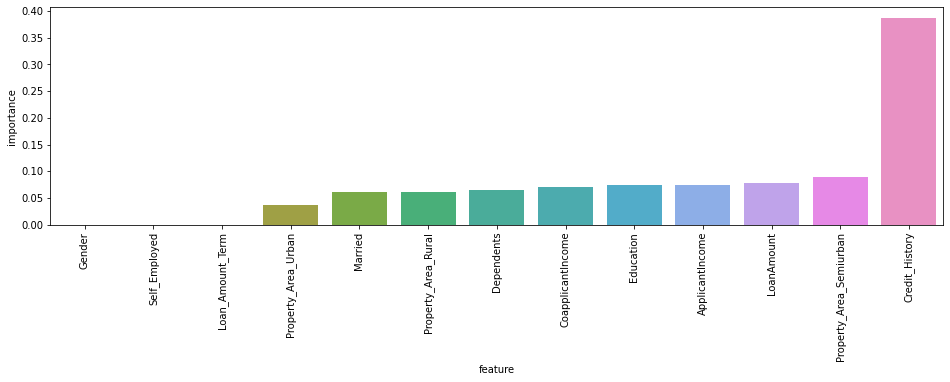

In [160]:
# Feature importances
FeatureXgb = pd.DataFrame({'feature':X_train.columns, 'importance':list(xgb_hyp.feature_importances_)}).sort_values('importance')
plt.figure(figsize=(16,4))
sns.barplot(data=FeatureXgb, x='feature', y='importance')
plt.xticks(rotation=90)
plt.show()